# Linear Group Contribution CMC Model

This notebook demonstrates feature extraction, linear model fitting, and subsequent feature selection for a group contribution model of CMC prediction.

In [1]:
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, NamedTuple

from rdkit.Chem import MolFromSmiles
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.linear_model import ElasticNetCV, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from camcann.data.io import DataReader, Datasets
from camcann.data.featurise import ECFPCountFeaturiser, SMILESHashes

HERE = Path(".")
HASH_PATH =  HERE / "full_hash.csv"
FEATURES_PATH = HERE / "features_df.csv"
RESULTS_PATH = HERE / "results.csv"
GROUP_CONTRIBS_PATH = HERE / "group_contribs.csv"

USE_SAVED_HASH: bool = False

## Data Loading

First, we load CMC values for 306 surfactants from a precompiled dataset, and convert the SMILES representations of every molecule to an RDKit `Mol` object.

In [2]:
data_reader = DataReader(Datasets.QIN)
all_data = data_reader.df
all_data.describe()

,log CMC
count,202.000000
mean,3.144909
std,1.209451
min,-0.795880
25%,2.397940
50%,3.356955
75%,3.967309
max,5.301030


In [3]:
all_molecules = [MolFromSmiles(smile) for smile in all_data.SMILES]
all_targets = all_data["log CMC"]

## Group counts extraction

Next, we identify all the groups with $\text{radius} \leq 2$ that appear in the molecules. Every group, has a unique hash, which is computed by the extraction algorithm, as well as its own index, $j$, which dictates the column of the resulting feature matrix, $\mathbf{G}$, that contains the count for that group, $N_j$. Each row of $\mathbf{G}$ corresponds to a molecule in the input array, $\vec{m}$:

$$\mathbf{G}_{ij} = N_j(\vec{m}_i).$$

The algorithm for extracting groups and their counts is a variant of ECFP. It iteratively updates a _hash map_, which contains the groups' SMILES fragments, hashes and indexes. It is important to store this; we can only learn group contributions for groups that appear in the training data, so that we must discard groups in the test data that do not appear in the hash map.

Here's an example for a small set of molecules:

In [4]:
example_feat = ECFPCountFeaturiser()

example_mols = ["CCC(C)(C)C", "OCCC(C)(C)C", "OC(=O)CC(C)(C)C"]
example_feats = example_feat.featurise_molecules([MolFromSmiles(mol) for mol in example_mols], radius=1)
example_df = example_feat.label_features(example_feats, example_mols)
example_df

,Num [CH3],Num [CH2],Num [C],Num [CH3][CH2],Num [CH3][CH2][C],Num [CH2][C]([CH3])([CH3])[CH3],Num [C][CH3],Num [OH],Num [CH2][OH],Num [CH2][CH2][OH],Num [CH2][CH2][C],Num [OH],Num [C],Num [O],Num [C][OH],Num [CH2][C](=[O])[OH],Num [C]=[O],Num [C][CH2][C]
CCC(C)(C)C,4,1,1,1,1,1,3,0,0,0,0,0,0,0,0,0,0,0
OCCC(C)(C)C,3,2,1,0,0,1,3,1,1,1,1,0,0,0,0,0,0,0
OC(=O)CC(C)(C)C,3,1,1,0,0,1,3,0,0,0,0,1,1,1,1,1,1,1


In [5]:
if HASH_PATH.exists() and USE_SAVED_HASH:
    smiles_hashes = SMILESHashes.load(HASH_PATH)
    featuriser = ECFPCountFeaturiser(smiles_hashes)
else:
    featuriser = ECFPCountFeaturiser()

In [6]:
all_features = featuriser.featurise_molecules(all_molecules, 2, add_new_hashes=True)
if USE_SAVED_HASH:
    featuriser.smiles_hashes.save(HASH_PATH)
print(f"Number of unique groups: {len(featuriser.smiles_hashes)}.")

Number of unique groups: 487.


The following snippet labels the columns so that we know which SMILES fragment each count is referring to. This isn't strictly necessary for fitting the data, but it is vital for interpretation.

In [7]:
features_df = featuriser.label_features(all_features, all_data.SMILES)
features_df.to_csv(FEATURES_PATH)

In [8]:
count_nonzero = features_df > 0
nnz = count_nonzero.sum()
num_shared = (nnz > 1).sum()
print(f"Number of groups that occur in multiple compounds: {num_shared}")

Number of groups that occur in multiple compounds: 344


Even using the full dataset, about a third of the groups we've discovered only appear once. These aren't useful features; the contributions will only apply to a single molecule, so we're likely to overfit.

## Model fitting and evaluation

To properly evaluate our model, we're going to use 10-fold cross-validation. For each of these folds, we will do the following procedure independently, so that we effectively simulate the real-world scenario of using the model to predict CMCs for arbitrary molecules that we've not seen before:

1. **Initial feature selection**: Remove groups that appear in only a single molecule in the training subset.
2. **Model fitting**: Fit a linear model using the count matrices. The model we're using is described in more detail below; there are some important considerations. One of these is that this model should be able to assign an importance score to each group.
3. **Final feature selection**: Using the group importance scores from the previous step, identify a smaller set of groups that retains similar predictive power to the full set. Having a smaller set of groups is ideal because we want to make the model more generalisable (we want to prioritise more common groups) and as simple as possible.


In [9]:
class FoldResults(NamedTuple):
    """Contains the results for a single fold's evaluation."""
    initial_groups: pd.Series
    pipeline: Pipeline
    test_rmse: float
    
    @property
    def train_cv_rmse(self) -> float:
        """Get the best RMSE from the train set cross-validation."""
        # mses = self.pipeline[-1].cv_values_
        # return np.min(np.mean(mses, axis=1))
        return -self.pipeline[-1].best_score_
    
    @property
    def reduced_num_features(self) -> int:
        """Get the number of features after final selection."""
        return self.pipeline[1].get_support().sum()
    
    @property
    def best_alpha(self) -> float:
        """Get the best alpha from ridge regression."""
        return self.pipeline[-1].alpha_
    
    def group_weights(self, all_groups: List[str]) -> Dict[str, float]:
        """Get the weights associated with each group after final training."""
        weights = self.pipeline[-1].coef_
        initial_idxs = np.flatnonzero(self.initial_groups.values)

        final_groups = self.pipeline[1].get_support()
        final_idxs = initial_idxs[final_groups]

        return {all_groups[idx]: weight for idx, weight in zip(final_idxs, weights)}

In [10]:
def single_fold_routine(train_idxs, test_idxs, linear: bool = True) -> FoldResults:
    """Perform a single fold training routine."""
    # Get train/test data split
    train_df = features_df.iloc[train_idxs]
    test_df = features_df.iloc[test_idxs]

    train_targets = all_targets.iloc[train_idxs]
    test_targets = all_targets.iloc[test_idxs]

    # 1. Remove features that only occur once
    has_group = train_df > 0
    include_group = has_group.sum() > 1

    train_feats = train_df.iloc[:, include_group.values]
    test_feats = test_df.iloc[:, include_group.values]

    # 2. Train initial model and 3. feature selection
    elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1])
    selector = SelectFromModel(elastic_net, threshold="mean")
    if linear:
        alphas = np.logspace(-10, 10, 21)
        out = RidgeCV(scoring="neg_root_mean_squared_error", alphas=alphas)
    else:
        out = GridSearchCV(
                MLPRegressor((15, 15), solver="lbfgs", max_iter=2000, random_state=0),
                {"alpha": list(10.0 ** -np.arange(1, 7))},
                scoring="neg_root_mean_squared_error",
            )
    pipe = make_pipeline(
        StandardScaler(),
        selector,
        out
    )
    pipe.fit(train_feats, train_targets)

    test_pred = pipe.predict(test_feats)
    test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred))

    return FoldResults(include_group, pipe, test_rmse)

In [11]:
fold_results: List[FoldResults] = []
for train_idx, test_idx in data_reader.cv_indexes:
    fold_results.append(single_fold_routine(train_idx, test_idx, True))

c:\Users\Alexander\anaconda3\envs\molplotly\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-02, tolerance: 2.089e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexander\anaconda3\envs\molplotly\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-02, tolerance: 2.089e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexander\anaconda3\envs\molplotly\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

## Results

Here we collect the results for each fold and the weights associated with their top 10 features.

In [12]:
results = defaultdict(list)
group_weights: List[Dict[str, float]] = []
for fold, result in enumerate(fold_results):
    results["Fold"].append(fold)
    results["Train RMSE"].append(result.train_cv_rmse)
    results["Initial num features"].append(result.initial_groups.sum())
    results["Final num features"].append(result.reduced_num_features)
    results["Alpha"].append(result.best_alpha)
    results["Test RMSE"].append(result.test_rmse)
    
    weights_dict = result.group_weights(featuriser.smiles_hashes.smiles)
    weights_dict["Fold"] = fold
    group_weights.append(weights_dict)

groups_df = pd.DataFrame(group_weights)
groups_df.to_csv(GROUP_CONTRIBS_PATH)

results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_PATH)

In [13]:
results_df

,Fold,Train RMSE,Initial num features,Final num features,Alpha,Test RMSE
0,0,0.384374,337,76,10.0,0.326464
1,1,0.386920,342,76,10.0,0.388470
2,2,0.351982,330,81,10.0,0.421738
3,3,0.375577,319,75,10.0,0.405892
4,4,0.374582,323,69,10.0,0.498724
5,5,0.395113,339,90,10.0,0.798534
6,6,0.391357,344,79,1.0,0.444982
7,7,0.377673,325,70,10.0,0.437559
8,8,0.386638,337,74,10.0,0.486744
9,9,0.295568,340,53,1.0,0.472016


In [14]:
groups_df.describe()

,[CH2],[C],[CH2][C]([CH3])([CH3])[CH3],[C][CH3],[CH2][OH],[CH2][CH2][CH2],[CH2][CH2][CH],[CH2][CH]([CH2])[OH],[CH2][CH2][CH2][CH2][CH2],[O],...,[CH2][N+]([CH3])([CH3])[CH2][C](=[O])[O-],[N+][CH2][C](=[O])[O-],[CH2][C]([N])=[O],[CH2][O][CH2][CH]([CH])[OH],[CH][CH]([OH])[CH]([OH])[CH2][O],[CH][CH2][O],[CH][O][CH]([O][CH2])[CH]([CH])[OH],[CH][CH2][O][CH]([CH])[O],[CH3][CH]([CH3])[CH2],[CH2][O][S]
count,10.000000,10.000000,9.000000,9.000000,10.000000,10.000000,10.000000,8.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,-0.199515,-0.112538,-0.019348,-0.019348,-0.079313,-0.504738,-0.221200,-0.059062,-0.600491,-0.138656,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744
std,0.126427,0.070948,0.003140,0.003140,0.059582,0.046657,0.049357,0.011613,0.075668,0.045194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.465445,-0.296846,-0.026369,-0.026369,-0.185920,-0.606805,-0.313623,-0.076437,-0.807864,-0.258352,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744
25%,-0.257691,-0.115078,-0.019798,-0.019798,-0.102683,-0.528702,-0.244842,-0.066020,-0.600793,-0.132568,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744
50%,-0.186089,-0.080719,-0.019337,-0.019337,-0.066468,-0.497513,-0.214449,-0.055877,-0.575228,-0.131359,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744
75%,-0.126422,-0.079312,-0.017474,-0.017474,-0.034967,-0.471264,-0.201044,-0.051880,-0.569444,-0.121849,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744
max,0.005911,-0.063256,-0.015313,-0.015313,-0.011230,-0.446865,-0.140184,-0.044975,-0.537750,-0.094772,...,-0.005791,-0.005791,-0.070021,-0.039604,-0.039604,-0.025508,0.040002,0.040002,0.071023,0.052744


In [15]:
print(f"Total score: {results_df['Test RMSE'].mean()}")

Total score: 0.46811250941217775


In [16]:
groups_df.fillna(0, inplace=True)
avg_contribs = groups_df.mean(axis=0)
avg_contribs.drop("Fold", inplace=True)
most_important = avg_contribs.sort_values(ascending=False, key=np.abs).head(20)
most_important

[CH2][CH2][CH2][CH2][CH2]               -0.600491
[CH2][CH2][CH2]                         -0.504738
[CH2][CH2][CH]                          -0.221200
[CH2]                                   -0.199515
[O][CH2][CH2][OH]                       -0.171524
[Cl-]                                    0.157110
[Br-]                                    0.155580
[O]                                     -0.138656
[C]                                     -0.112538
[C][CH]([OH])[CH]([OH])[CH]([CH])[OH]   -0.099492
[CH][CH2][CH2][CH2][CH2]                -0.089183
[N]                                     -0.087134
[CH2][CH2][CH2][CH2][N+]                 0.080213
[CH2][OH]                               -0.079313
[CH2][CH2][CH2][O][S]                    0.075566
[CH2][CH2][CH2][CH2][S]                  0.073878
[CH2][CH2][CH2][CH2][O]                 -0.073291
[Na+]                                    0.072149
[c][cH][cH]                             -0.068868
[C][F]                                  -0.068088


Text(0.5, 0.98, 'Ridge model, optimum regularization')

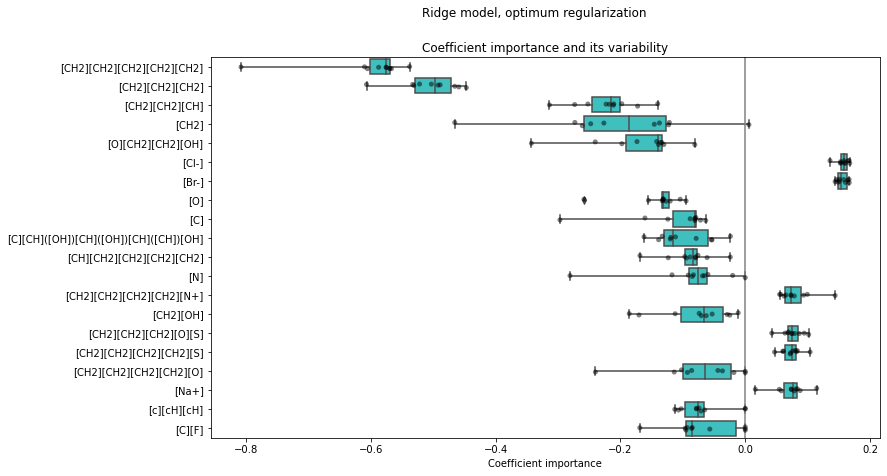

In [17]:
plt.figure(figsize=(12, 7))
sns.stripplot(data=groups_df[most_important.index], orient="h", color="k", alpha=0.5)
sns.boxplot(data=groups_df[most_important.index], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, optimum regularization")